In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import xarray as xr
import numpy as np
import pprint
import glob
import skill_metrics as sm

all_bias=xr.open_dataset('/Users/ignasi/Desktop/Oceanography/IEO/projects/cmip6_stratification/data/processed/allbias.nc')


In [5]:
print(360-120)
print(360-75)


180
240


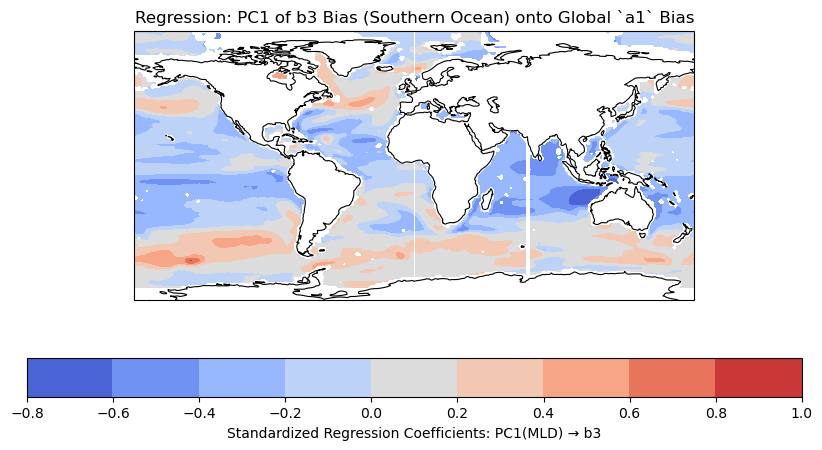

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

ds = all_bias  # Update with correct path

region_MLD = {"lat": slice(-60, -50),"lon": (slice(0, 300), slice(300, 360))}  # Southern Ocean
D1_bias = xr.concat([ds["D1"].sel(lat=region_MLD["lat"], lon=region_MLD["lon"][0]),
                    ds["D1"].sel(lat=region_MLD["lat"], lon=region_MLD["lon"][1])],dim='lon')# Extract region

D1_bias_mean = D1_bias.mean(dim=["lat", "lon"])  # Shape: (22 models, 12 months)

D1_bias_final = D1_bias_mean.mean(dim="month").values  # Shape: (22,)

scaler_mld = StandardScaler()
D1_bias_final_normalized = scaler_mld.fit_transform(D1_bias_final.reshape(-1, 1)).flatten()

pca = PCA(n_components=1)  # Extract leading mode
pc1_scores = pca.fit_transform(D1_bias_final_normalized.reshape(-1, 1)).flatten()  # Shape: (22,)


b3_bias = ds["a1"].mean(dim="month")  # Compute annual mean of `b3` bias
lat_glob, lon_glob = ds.lat.values, ds.lon.values  # Global lat-lon coordinates

regression_map = np.full((lat_glob.shape[0], lon_glob.shape[0]), np.nan)  # Initialize with NaNs


b3_bias_values = b3_bias.values  

for i in range(lat_glob.shape[0]):
    for j in range(lon_glob.shape[0]):
        y = b3_bias_values[:, i, j] 

        if np.isnan(y).any():  
            continue
        

        y_standardized = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()


        reg_model = LinearRegression()
        reg_model.fit(pc1_scores.reshape(-1, 1), y_standardized.reshape(-1, 1))  # Fit PC1 onto standardized b3 bias
        regression_map[i, j] = reg_model.coef_[0][0]  # Store regression coefficient


plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.contourf(lon_glob, lat_glob, regression_map, cmap="coolwarm", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
plt.colorbar(im, orientation="horizontal", label="Standardized Regression Coefficients: PC1(MLD) → b3")
ax.set_title("Regression: PC1 of b3 Bias (Southern Ocean) onto Global `a1` Bias")
plt.show()


In [22]:
D1_bias_mean.model

<xarray.DataArray 'model' (model: 22)>
array(['E3SM-1-0', 'NorESM2-LM', 'CMCC-CM2', 'MIROC6', 'IPSL-CM6A-LR', 'NESM3',
       'FGOALS-f3-L', 'EC-Earth3-Veg', 'SAM0-UNICON', 'MPI-ESM2', 'EC-Earth3',
       'BCC-CSM2-MR', 'ACCESS-CM2', 'CESM2', 'GFDL-ESM4', 'E3SM-1-1-ECA',
       'BCC-ESM1', 'UKESM1-1', 'MRI-ESM2', 'CanESM5', 'GISS-E2', 'FIO-ESM2'],
      dtype=object)
Coordinates:
  * model    (model) object 'E3SM-1-0' 'NorESM2-LM' ... 'GISS-E2' 'FIO-ESM2'
    number   int64 0